# Analyzing Breast Cancer Diagnostic Data

## About the Data
The UCI Machine Learning Repository has a dataset containing of 569 images of a cancer tumor. https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

The dataset contains these columns for each image:
- id
- diagnosis (Malignant or Benign) 
- radius (mean of distance from center to points on the perimeter)
- texture (standard dev. of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness as defined by:
  - $$\frac{perimeter^2}{area - 1.0}$$
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (coastlineApproximation - 1)

Besides for `id` and `diagnosis`, each of those categories were collected three times for each image to calculate the mean, standard error, and worst/largest value for each feature. This effectively produced 30 features.

## Primary Goals
In this project, I wanted to...
1. Create the most effective model which can predict if a cancer tumor is benign or malignant. 
2. Determine weaknesses and strengths of said solution

----
## Initial Data Load
Because the data is a CSV file with both text & numbers, it's ideal to load it as a Pandas DataFrame

#### Splitting Data
We first split the data by using the `train_test_split` function in scikit learn. This function lets me split the data randomly everytime such that x% of data is used for training and the remaining 1-x% is used for testing.

For this project, I elected to have 30% of my data be used for testing and the remaining 70% to be used for training.

In [10]:
def split_data(data_df):
    """ Creates a input train, input test, output train, and output test
        data set where 'diagnosis' is the column for output
    """
    out_df = data_df['diagnosis']
    in_df = data_df.drop('diagnosis', axis=1)
    return model_selection.train_test_split(in_df, out_df, test_size=0.30)

#### Cleaning Data
While the data is mostly clean, we can improve the memory footprint of this script by converting the `diagnosis` column to a Pandas Categorical. This column is currently a binary value between the string values of "M" or "B". By converting it to a categorical type we can retain this easy to understand values from the front-end, but reassign these values to integers on the back-end, which improves resources. http://pandas.pydata.org/pandas-docs/stable/categorical.html

In [11]:
import os
import pandas as pd


def main():
    # Loads CSV File
    data_df = pd.read_csv('data.csv', index_col=0)
    data_df = data_df.iloc[:, :-1]

    # Cleans CSV File
    data_df['diagnosis'] = data_df['diagnosis'].astype('category')

    # Splits CSV file
    in_train, in_test, out_train, out_test = split_data(data_df)

----
## Comparing Machine Learning Models
Scikit-Learn now provides tools to compare several machine learning models against each other at the same time. This gave me the opportunity to quickly see how each model reacts to this dataset.

The function below does three things:
1. It creates a cross validation score configuration where we can compare the training inputs and calculate the accuracy between the predicted training output & the actual training output.
2. We repeat that process for 20 folds over each model we want to test, which includes:
  1. Logistic Regression
  2. Linear Discriminant Analysis
  3. Quadratic Discriminant Analysis
  4. K Neighbors Classifier
  5. Decision Tree Classifier
  6. Guassian NB
  7. SVC
3. We plot the accuracies across all 20 folds & models to a violin plot.

In [12]:
from sklearn import discriminant_analysis, linear_model, model_selection, naive_bayes, neighbors, svm, tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def scikit_validator(in_train, out_train):
    """ Tests Scikit Learn models against training data

        Conclusions was that Logistic Regression (Mean 0.949 & SD 0.033) and
        LinearDiscriminantAnalysis (Mean 0.956 & SD 0.033) were the best. LDA
        is consistently high while LR is most likely to perform dead on.

    """
    # Spot Check Algorithms
    models = []
    models.append(('LR', linear_model.LogisticRegression()))
    models.append(('LDA', discriminant_analysis.LinearDiscriminantAnalysis()))
    models.append(('QDA', discriminant_analysis.QuadraticDiscriminantAnalysis()))
    models.append(('KNN', neighbors.KNeighborsClassifier()))
    models.append(('TREE', tree.DecisionTreeClassifier()))
    models.append(('NB', naive_bayes.GaussianNB()))
    models.append(('SVM', svm.SVC()))

    # Evaluate Model
    sk_summary = {}
    for name, model in models:
        kfold = model_selection.KFold(n_splits=20)
        results = model_selection.cross_val_score(model, in_train, out_train,
                                                  cv=kfold, scoring='accuracy')
        sk_summary[name] = results
        print('{}: {} ({})'.format(name, results.mean(), results.std()))

    # Plots Results
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Algorithm Comparison')
    plt.violinplot([sk_summary[x] for x in sk_summary])
    ax.set_xticks(range(1,9,1))
    ax.set_xticklabels([x for x in sk_summary])
    plt.show()
    
    return sk_summary

We will run this function on only our training data initially, because at this point, I'm not too worried about the repeatability of each model quite yet. I'm just trying to find the models with perform the best with the least fussing & tweaking.

LR: 0.9446052631578945 (0.05915187153266727)
LDA: 0.95 (0.04183300132670378)
QDA: 0.945 (0.049749371855330994)
KNN: 0.9222368421052632 (0.04617258813123693)
TREE: 0.9097368421052631 (0.053661630958433536)
NB: 0.9246052631578948 (0.04881756274265402)
SVM: 0.6010526315789474 (0.09270257446813107)


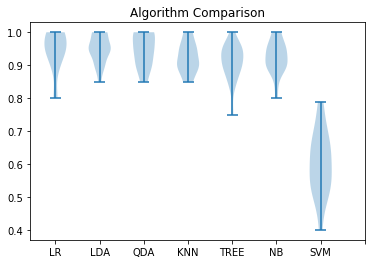

In [13]:
def main():
    # Loads CSV File
    data_df = pd.read_csv('data.csv', index_col=0)
    data_df = data_df.iloc[:, :-1]

    # Cleans CSV File
    data_df['diagnosis'] = data_df['diagnosis'].astype('category')

    # Splits CSV file
    in_train, in_test, out_train, out_test = split_data(data_df)
    sk_summary = scikit_validator(in_train, out_train)

main()

The results right out of the gate suggest that practically every model, besides an SVM, would perform well with our dataset.

I wanted to initially compare the differences between an LDA & QDA model because they both were the top two models which had the best accuracy, even when they performed at their worst. I will investigate this in the next section.

It's also worth noting that this dataset is awfully small at 600 datapoints alone and is practically numerical based. If this dataset was any larger and/or had more 'bad' data, it's possible these models would not suffice anymore and we would have to investigate new models.

----
## Comparing LDA & QDA
I began by creating two functions. One function establishes an LDA model.

In [14]:
def lda(in_train, out_train, in_test, out_test):
    # Creates Model & Fits Model
    lda = discriminant_analysis.LinearDiscriminantAnalysis()
    lda.fit(in_train, out_train)

    # Generates Coefficients for Feature Importance
    coef = lda.coef_

    # Creates Predictions & Generates Confusion Matrix Data
    predict = pd.Series(lda.predict(in_test))
    matrix = confusion_matrix(out_test, predict)
    return matrix, coef

And the second function establishes a QDA model.

In [15]:
def qda(in_train, out_train, in_test, out_test):
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    qda.fit(in_train, out_train)

    predict = pd.Series(qda.predict(in_test))
    matrix = confusion_matrix(out_test, predict)
    return matrix

I also created a helper function to create a Confusion Matrix so I can compare the predicted outputs vs. the actual outputs from the test data. This will help me guage the accuracy of both models in regards of specifically figuring out where the models fell apart.

In [16]:
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes, qty, title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    cm_flat = np.vstack([np.array(x).reshape(1, 4) for x in cm])
    cm_sum = cm_flat.sum(axis=0).reshape(2, 2)
    cm_avg = cm_sum / qty

    plt.imshow(cm_avg, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_avg.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm_avg[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_avg[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

I also created a helper function to help me visualize the importance of each feature in the LDA model.

In [17]:
import itertools
from matplotlib import pyplot as plt

def create_feature_importance(cm, features, qty, title):
    """
    This function plots the Feature Importance
    """
    cm_flat = np.vstack([np.array(x) for x in cm])
    cm_sum = cm_flat.sum(axis=0)
    cm_avg = cm_sum / qty

    fig, ax = plt.subplots(1, 1)
    ax.bar(range(len(cm_avg)), cm_avg, 0.5)
    ax.set_title(title)
    ax.set_xticks(range(len(cm_avg)))
    ax.set_xticklabels(features, rotation=90)
    plt.show()

I then invoked both functions from the main function

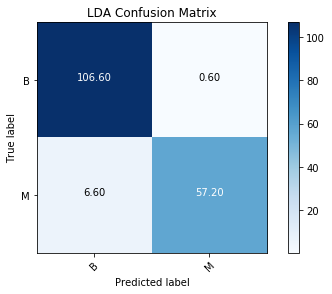

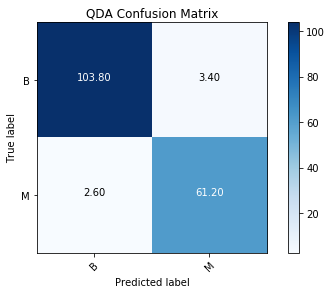

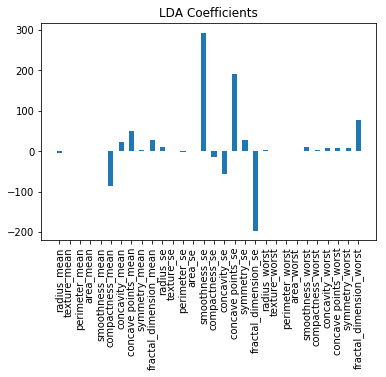

In [18]:
def main():
    # Loads CSV File
    data_df = pd.read_csv('data.csv', index_col=0)
    data_df = data_df.iloc[:, :-1]

    # Cleans CSV File
    data_df['diagnosis'] = data_df['diagnosis'].astype('category')

    # Creates Structures to store data from iterations
    lda_cm_all = []
    lda_coef_all = []
    qda_cm_all = []
    max_qty = 10

    for split in range(0, max_qty, 1):
        # Splits Data
        in_train, in_test, out_train, out_test = split_data(data_df)

        # Fits & Predicts Model
        lda_cm, lda_coef = lda(in_train, out_train, in_test, out_test)
        qda_cm = qda(in_train, out_train, in_test, out_test)

        # Adds data to unified data store
        lda_cm_all.append(lda_cm)
        lda_coef_all.append(lda_coef)
        qda_cm_all.append(qda_cm)
        
    # Plots Confusion Matrix
    classes = out_test.unique()
    plot_confusion_matrix(lda_cm_all, classes, qty=max_qty,
                          title='LDA Confusion Matrix',
                          cmap=plt.cm.Blues)
    plot_confusion_matrix(qda_cm_all, classes, qty=max_qty,
                          title='QDA Confusion Matrix',
                          cmap=plt.cm.Blues)

    # Calculates Feature Importance
    features = in_test.columns.unique()
    create_feature_importance(lda_coef_all, features, max_qty,
                              title='LDA Coefficients')

main()

The Confusion Matrix suggests that this dataset is easily learned. But I wanted to know which Features assist in the learning process. To assist, I created a function to help plot the feature importance for the LDA model.

----
## Conclusions

Looking at the Confusion Matrix, the model appears to correctly predict the right value for each image most of the time.

Looking at the Feature Importance for the LDA model, the following features are most used in descending order of importance:
- Standard Error for Smoothness
- Standard Error for Concave Points
- Worst Value for Fractical Dimension
- Standard Error for Symmetry

Coincidentally, the Standard Error for Fractical Dimensions is the worst performer in predicing cancer tumors too.

But, it's hard to argue against sticking with the LDQ or QDA models for the time being. The accuracy of this model is surprisingly strong given the confusion matrix, the accuracy success of the other models, and how we've yet to do signifcant tuning to any model other than using the defaults. It's possible that these models are over-training to a slight extent, but with a dataset of only 700 samples, we'd be hard-pressed to engineer a better solution with great certainty until we have more data.